In [1]:
# Install required packages
!pip install wandb -q

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from tqdm.notebook import tqdm
import wandb
import random

In [2]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb key") 

wandb.login(key=my_secret)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dishitagoyal25 (dishitagoyal25-manipal-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Define hyperparameters
config = {
    "latent_dim": 100,
    "generator_features": 64,
    "discriminator_features": 64,
    "image_size": 64,
    "batch_size": 128,
    "learning_rate": 0.0002,
    "beta1": 0.5,
    "beta2": 0.999,
    "epochs": 50,
    "seed": 42
}

# Initialize a new wandb run
run = wandb.init(
    project="anime-face-generation",
    config=config,
    name="DCGAN-Anime-Faces"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [4]:
class AnimeFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.CenterCrop(config['image_size']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Set random seed for reproducibility
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['seed'])

# Load the dataset
# For Kaggle's anime-faces dataset

dataset_path = "/kaggle/input/animefacedataset/images"
dataset = AnimeFacesDataset(root_dir=dataset_path, transform=transform)

# Split dataset into train and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Print dataset information
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")


Total images: 63565
Training images: 57208
Validation images: 6357


In [6]:
#Model Architecture

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent vector z
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is 3 x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

netG = Generator(config['latent_dim'], config['generator_features']).to(device)
netD = Discriminator(config['discriminator_features']).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

# Print model summaries
print(netG)
print(netD)

Using device: cuda
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

In [7]:
#Training Function

# Function to generate and save sample images
def save_samples(epoch, fixed_noise):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    
    # Create a grid of images
    img_grid = make_grid(fake, padding=2, normalize=True)
    
    # Convert to numpy for wandb logging
    img_np = img_grid.numpy().transpose((1, 2, 0))
    
    # Log to wandb
    wandb.log({f"generated_samples_epoch_{epoch}": wandb.Image(img_np)})
    
    # Save locally
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images - Epoch {epoch}")
    plt.imshow(img_np)
    plt.savefig(f"generated_samples_epoch_{epoch}.png")
    plt.close()

# Function to save model checkpoints
def save_checkpoint(epoch):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': netG.state_dict(),
        'discriminator_state_dict': netD.state_dict(),
        'optimizer_G_state_dict': optimizerG.state_dict(),
        'optimizer_D_state_dict': optimizerD.state_dict(),
    }, f"dcgan_checkpoint_epoch_{epoch}.pt")
    
    # Log model to wandb
    wandb.save(f"dcgan_checkpoint_epoch_{epoch}.pt")

In [8]:
#Training Loop

# Setup loss function and optimizers
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=config['learning_rate'], betas=(config['beta1'], config['beta2']))
optimizerG = optim.Adam(netG.parameters(), lr=config['learning_rate'], betas=(config['beta1'], config['beta2']))

# Create fixed noise for generating samples
fixed_noise = torch.randn(64, config['latent_dim'], 1, 1, device=device)

# Labels for real and fake data
real_label = 1.0
fake_label = 0.0

# Training loop
print("Starting Training Loop...")

# Lists to keep track of progress
G_losses = []
D_losses = []
val_G_losses = []
val_D_losses = []

for epoch in range(config['epochs']):
    # Training phase
    netG.train()
    netD.train()
    
    running_d_loss = 0.0
    running_g_loss = 0.0
    
    # Create a tqdm progress bar for the training loader
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]")
    
    for i, data in enumerate(train_pbar):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with real data
        netD.zero_grad()
        real_cpu = data.to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with fake data
        noise = torch.randn(batch_size, config['latent_dim'], 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        
        # Update running losses
        running_d_loss += errD.item()
        running_g_loss += errG.item()
        
        # Update tqdm progress bar
        train_pbar.set_postfix({
            'D_loss': errD.item(),
            'G_loss': errG.item(),
            'D(x)': D_x,
            'D(G(z))': D_G_z2
        })
    
    # Calculate average training losses for this epoch
    avg_train_d_loss = running_d_loss / len(train_loader)
    avg_train_g_loss = running_g_loss / len(train_loader)
    
    G_losses.append(avg_train_g_loss)
    D_losses.append(avg_train_d_loss)
    
    # Validation phase
    netG.eval()
    netD.eval()
    
    val_running_d_loss = 0.0
    val_running_g_loss = 0.0
    
    # Create a tqdm progress bar for the validation loader
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]")
    
    with torch.no_grad():
        for i, data in enumerate(val_pbar):
            # Validate discriminator
            real_cpu = data.to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            
            output = netD(real_cpu).view(-1)
            errD_real = criterion(output, label)
            D_x = output.mean().item()
            
            # Generate fake data
            noise = torch.randn(batch_size, config['latent_dim'], 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            
            output = netD(fake.detach()).view(-1)
            errD_fake = criterion(output, label)
            D_G_z1 = output.mean().item()
            
            errD = errD_real + errD_fake
            
            # Validate generator
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            D_G_z2 = output.mean().item()
            
            # Update running validation losses
            val_running_d_loss += errD.item()
            val_running_g_loss += errG.item()
            
            # Update tqdm progress bar
            val_pbar.set_postfix({
                'Val_D_loss': errD.item(),
                'Val_G_loss': errG.item(),
                'Val_D(x)': D_x,
                'Val_D(G(z))': D_G_z2
            })
    
    # Calculate average validation losses for this epoch
    avg_val_d_loss = val_running_d_loss / len(val_loader)
    avg_val_g_loss = val_running_g_loss / len(val_loader)
    
    val_G_losses.append(avg_val_g_loss)
    val_D_losses.append(avg_val_d_loss)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_discriminator_loss": avg_train_d_loss,
        "train_generator_loss": avg_train_g_loss,
        "val_discriminator_loss": avg_val_d_loss,
        "val_generator_loss": avg_val_g_loss
    })
    
    # Generate and save sample images
    if (epoch + 1) % 5 == 0 or epoch == 0:
        save_samples(epoch + 1, fixed_noise)
    
    # Save model checkpoints
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        save_checkpoint(epoch + 1)
    
    print(f"Epoch {epoch+1}/{config['epochs']} - "
          f"Train: [D loss: {avg_train_d_loss:.4f}, G loss: {avg_train_g_loss:.4f}] - "
          f"Val: [D loss: {avg_val_d_loss:.4f}, G loss: {avg_val_g_loss:.4f}]")

# Finish the wandb run
wandb.finish()

Starting Training Loop...


Epoch 1/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 - Train: [D loss: 0.7245, G loss: 8.0209] - Val: [D loss: 0.6717, G loss: 2.6016]


Epoch 2/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50 - Train: [D loss: 0.6949, G loss: 6.1383] - Val: [D loss: 4.2626, G loss: 5.9981]


Epoch 3/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50 - Train: [D loss: 0.5511, G loss: 6.0209] - Val: [D loss: 1.0749, G loss: 3.6332]


Epoch 4/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50 - Train: [D loss: 0.4734, G loss: 6.1728] - Val: [D loss: 1.2538, G loss: 2.4136]


Epoch 5/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50 - Train: [D loss: 0.4302, G loss: 6.0191] - Val: [D loss: 0.6091, G loss: 2.2009]


Epoch 6/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50 - Train: [D loss: 0.4779, G loss: 5.7972] - Val: [D loss: 1.0019, G loss: 2.1012]


Epoch 7/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50 - Train: [D loss: 0.4719, G loss: 5.5684] - Val: [D loss: 0.6792, G loss: 1.5711]


Epoch 8/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50 - Train: [D loss: 0.4909, G loss: 5.2686] - Val: [D loss: 0.8904, G loss: 2.1135]


Epoch 9/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50 - Train: [D loss: 0.4635, G loss: 5.0311] - Val: [D loss: 1.0950, G loss: 3.4010]


Epoch 10/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50 - Train: [D loss: 0.5073, G loss: 4.8180] - Val: [D loss: 0.8478, G loss: 1.8029]


Epoch 11/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50 - Train: [D loss: 0.4796, G loss: 4.8195] - Val: [D loss: 1.7265, G loss: 5.9103]


Epoch 12/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50 - Train: [D loss: 0.5079, G loss: 4.6580] - Val: [D loss: 1.6110, G loss: 0.4957]


Epoch 13/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50 - Train: [D loss: 0.4839, G loss: 4.4331] - Val: [D loss: 1.9468, G loss: 3.3645]


Epoch 14/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50 - Train: [D loss: 0.4839, G loss: 4.1463] - Val: [D loss: 0.7971, G loss: 1.8362]


Epoch 15/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50 - Train: [D loss: 0.4829, G loss: 4.3014] - Val: [D loss: 0.7809, G loss: 2.9756]


Epoch 16/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50 - Train: [D loss: 0.5320, G loss: 4.0586] - Val: [D loss: 1.3663, G loss: 0.6782]


Epoch 17/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50 - Train: [D loss: 0.5052, G loss: 3.9433] - Val: [D loss: 2.3266, G loss: 3.6457]


Epoch 18/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50 - Train: [D loss: 0.4983, G loss: 3.9638] - Val: [D loss: 1.0300, G loss: 1.3419]


Epoch 19/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50 - Train: [D loss: 0.5145, G loss: 3.8268] - Val: [D loss: 0.8848, G loss: 1.7785]


Epoch 20/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50 - Train: [D loss: 0.4193, G loss: 3.9263] - Val: [D loss: 1.0008, G loss: 2.2893]


Epoch 21/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50 - Train: [D loss: 0.5032, G loss: 3.9902] - Val: [D loss: 1.4658, G loss: 2.3589]


Epoch 22/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50 - Train: [D loss: 0.4191, G loss: 4.0322] - Val: [D loss: 0.8843, G loss: 2.6133]


Epoch 23/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/50 - Train: [D loss: 0.4204, G loss: 4.0078] - Val: [D loss: 0.6573, G loss: 2.4091]


Epoch 24/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/50 - Train: [D loss: 0.5202, G loss: 4.0106] - Val: [D loss: 1.2421, G loss: 2.2802]


Epoch 25/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/50 - Train: [D loss: 0.4089, G loss: 3.9468] - Val: [D loss: 0.9751, G loss: 2.0287]


Epoch 26/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/50 - Train: [D loss: 0.4479, G loss: 4.1239] - Val: [D loss: 1.0246, G loss: 0.9746]


Epoch 27/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/50 - Train: [D loss: 0.4084, G loss: 4.2360] - Val: [D loss: 2.1099, G loss: 3.0945]


Epoch 28/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/50 - Train: [D loss: 0.4350, G loss: 3.9339] - Val: [D loss: 0.9074, G loss: 1.9199]


Epoch 29/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/50 - Train: [D loss: 0.4055, G loss: 4.0043] - Val: [D loss: 1.2895, G loss: 2.8576]


Epoch 30/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30/50 - Train: [D loss: 0.3238, G loss: 4.2270] - Val: [D loss: 0.5243, G loss: 1.5863]


Epoch 31/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31/50 - Train: [D loss: 0.4828, G loss: 4.1084] - Val: [D loss: 0.8916, G loss: 1.0006]


Epoch 32/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32/50 - Train: [D loss: 0.4156, G loss: 4.1356] - Val: [D loss: 2.2385, G loss: 3.9002]


Epoch 33/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33/50 - Train: [D loss: 0.3823, G loss: 4.0055] - Val: [D loss: 0.7092, G loss: 1.8086]


Epoch 34/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34/50 - Train: [D loss: 0.4892, G loss: 4.0255] - Val: [D loss: 1.0168, G loss: 1.9177]


Epoch 35/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35/50 - Train: [D loss: 0.3577, G loss: 4.2867] - Val: [D loss: 1.1599, G loss: 2.4294]


Epoch 36/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36/50 - Train: [D loss: 0.4588, G loss: 4.0179] - Val: [D loss: 1.0534, G loss: 2.2013]


Epoch 37/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37/50 - Train: [D loss: 0.3317, G loss: 4.2338] - Val: [D loss: 1.2958, G loss: 2.9509]


Epoch 38/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38/50 - Train: [D loss: 0.4288, G loss: 4.1416] - Val: [D loss: 1.3189, G loss: 2.1735]


Epoch 39/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 39/50 - Train: [D loss: 0.4090, G loss: 4.1281] - Val: [D loss: 1.2080, G loss: 2.2612]


Epoch 40/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 40/50 - Train: [D loss: 0.3918, G loss: 4.1697] - Val: [D loss: 6.3943, G loss: 6.9074]


Epoch 41/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 41/50 - Train: [D loss: 0.4258, G loss: 4.1219] - Val: [D loss: 1.1519, G loss: 2.0137]


Epoch 42/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 42/50 - Train: [D loss: 0.1835, G loss: 4.5826] - Val: [D loss: 0.5208, G loss: 2.9364]


Epoch 43/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 43/50 - Train: [D loss: 0.3509, G loss: 4.3810] - Val: [D loss: 1.0095, G loss: 1.8522]


Epoch 44/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 44/50 - Train: [D loss: 0.4885, G loss: 4.1967] - Val: [D loss: 1.1454, G loss: 2.3747]


Epoch 45/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 45/50 - Train: [D loss: 0.3861, G loss: 4.0724] - Val: [D loss: 0.8223, G loss: 2.2385]


Epoch 46/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 46/50 - Train: [D loss: 0.4452, G loss: 4.1666] - Val: [D loss: 1.4011, G loss: 2.5122]


Epoch 47/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 47/50 - Train: [D loss: 0.3403, G loss: 4.2824] - Val: [D loss: 0.7969, G loss: 1.2017]


Epoch 48/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 48/50 - Train: [D loss: 0.4097, G loss: 4.1182] - Val: [D loss: 1.0693, G loss: 2.7600]


Epoch 49/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49/50 - Train: [D loss: 0.3122, G loss: 4.3762] - Val: [D loss: 1.1093, G loss: 2.7386]


Epoch 50/50 [Train]:   0%|          | 0/447 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 50/50 - Train: [D loss: 0.3529, G loss: 4.2710] - Val: [D loss: 0.8225, G loss: 2.7648]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_discriminator_loss,██▆▅▄▅▅▅▅▅▅▅▅▆▅▅▄▅▄▅▄▄▄▄▃▄▄▅▃▅▄▄▄▄▁▅▄▄▄▃
train_generator_loss,█▅▅▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▂▂▂▁▂▂▁▂▂▁▂
val_discriminator_loss,▁▅▂▂▁▁▁▁▂▂▁▁▂▃▂▂▂▁▁▂▂▃▁▂▁▃▁▂▂▂▂▂█▂▁▁▂▁▂▁
val_generator_loss,▃▇▄▃▃▂▃▄▂▇▄▂▄▁▄▂▃▃▃▃▁▄▂▃▂▅▂▃▃▄▃█▃▄▂▃▃▂▃▃
epoch,50
train_discriminator_loss,0.3529
train_generator_loss,4.27098
val_discriminator_loss,0.82252
val_generator_loss,2.76483


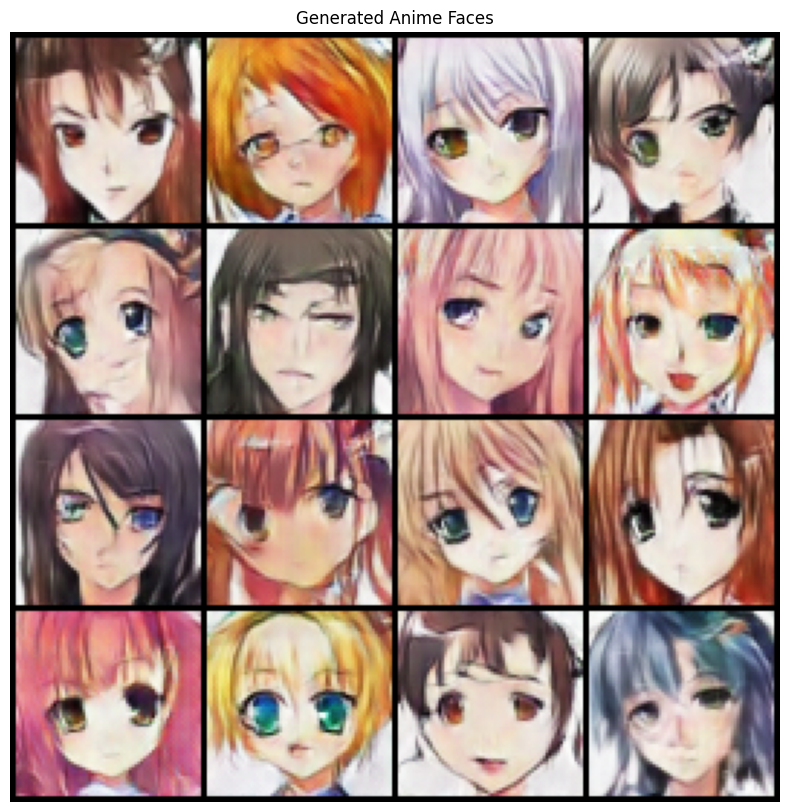

In [9]:
#Generating images with the Trained Model

# Generate a grid of images
def generate_images(num_images=16):
    # Create random noise
    noise = torch.randn(num_images, config['latent_dim'], 1, 1, device=device)
    
    # Generate images
    with torch.no_grad():
        fake = netG(noise).detach().cpu()
    
    # Create a grid of images
    img_grid = make_grid(fake, padding=2, normalize=True, nrow=int(np.sqrt(num_images)))
    
    # Convert to numpy for display
    img_np = img_grid.numpy().transpose((1, 2, 0))
    
    # Display the images
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Anime Faces")
    plt.imshow(img_np)
    plt.show()

# Generate 16 images
generate_images(16)


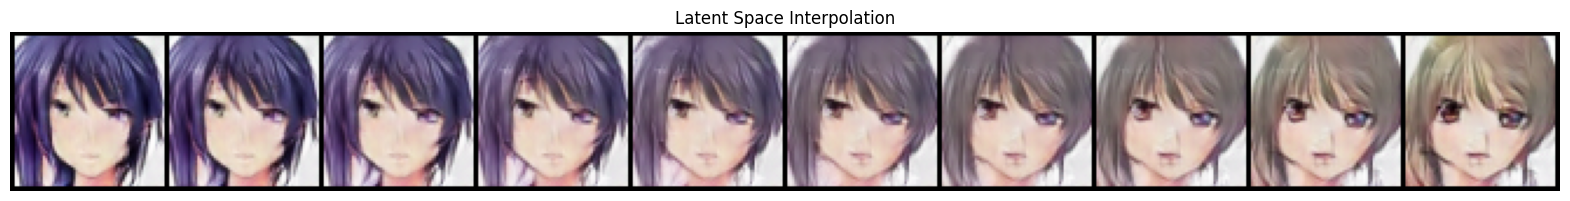

Error: You must call wandb.init() before wandb.log()

In [10]:
def interpolate_latent_space(num_steps=10):
    # Generate two random latent vectors
    z1 = torch.randn(1, config['latent_dim'], 1, 1, device=device)
    z2 = torch.randn(1, config['latent_dim'], 1, 1, device=device)
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, num_steps)
    
    # Generate images for each interpolation step
    images = []
    with torch.no_grad():
        for alpha in alphas:
            # Linear interpolation between z1 and z2
            z_interp = z1 * (1 - alpha) + z2 * alpha
            # Generate image from interpolated latent vector
            fake = netG(z_interp).detach().cpu()
            # Add to list of images
            images.append(fake[0])
    
    # Create a grid of images
    img_grid = make_grid(images, padding=2, normalize=True, nrow=num_steps)
    
    # Convert to numpy for display
    img_np = img_grid.numpy().transpose((1, 2, 0))
    
    # Display the images
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.title("Latent Space Interpolation")
    plt.imshow(img_np)
    plt.savefig("latent_space_interpolation.png")
    plt.show()
    
    # Log to wandb
    wandb.log({"latent_space_interpolation": wandb.Image(img_np)})

# Call the function to generate interpolated images
interpolate_latent_space(10)

In [12]:
!pip install -q pytorch-fid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [15]:
# Import necessary libraries
from pytorch_fid import fid_score
import os
from PIL import Image
import torch
import numpy as np
from tqdm.notebook import tqdm

# Create a directory of properly resized images for FID calculation
def prepare_real_images_for_fid(dataset_path, output_path, target_size=64):
    """Resize and save real images for FID calculation"""
    os.makedirs(output_path, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f)) 
                  and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Preparing {len(image_files)} real images for FID calculation...")
    
    for i, img_file in enumerate(tqdm(image_files)):
        try:
            img_path = os.path.join(dataset_path, img_file)
            img = Image.open(img_path).convert('RGB')
            
            # Resize to target size
            img = img.resize((target_size, target_size), Image.LANCZOS)
            
            # Save to output directory
            img.save(os.path.join(output_path, f"real_{i:05d}.png"))
            
            # Only process a subset if there are too many images
            if i >= 1000:
                break
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    print(f"Prepared {min(i+1, 1000)} real images for FID calculation")

# Save generated images for FID calculation
def save_images_for_fid(num_images=1000, target_size=64):
    output_path = "generated_images_fid"
    os.makedirs(output_path, exist_ok=True)
    
    print(f"Generating {num_images} images for FID calculation...")
    
    with torch.no_grad():
        for i in tqdm(range(0, num_images, config['batch_size'])):
            current_batch_size = min(config['batch_size'], num_images - i)
            noise = torch.randn(current_batch_size, config['latent_dim'], 1, 1, device=device)
            fake = netG(noise).detach().cpu()
            
            # Denormalize and save images
            for j, img in enumerate(fake):
                if i + j >= num_images:
                    break
                    
                img = (img * 0.5 + 0.5) * 255  # Denormalize
                img = img.permute(1, 2, 0).numpy().astype(np.uint8)
                
                # Save image
                Image.fromarray(img).save(os.path.join(output_path, f"fake_{i+j:05d}.png"))
    
    print(f"Generated {num_images} images for FID calculation")
    return output_path

# Calculate FID score
def calculate_fid(real_images_path, generated_images_path):
    """Calculate FID score between real and generated images"""
    print(f"Calculating FID score between {real_images_path} and {generated_images_path}...")
    
    try:
        fid_value = fid_score.calculate_fid_given_paths(
            [real_images_path, generated_images_path],
            batch_size=50,
            device=device,
            dims=2048
        )
        print(f"FID Score: {fid_value}")
        return fid_value
    except Exception as e:
        print(f"Error calculating FID score: {e}")
        return None

# Main function to run FID evaluation
def run_fid_evaluation(dataset_path, num_images=1000):
    # Prepare real images
    real_images_path = "real_images_fid"
    prepare_real_images_for_fid(dataset_path, real_images_path)
    
    # Generate fake images
    fake_images_path = save_images_for_fid(num_images)
    
    # Calculate FID score
    fid = calculate_fid(real_images_path, fake_images_path)
    
    if fid is not None:
        wandb.log({"FID_score": fid})
    
    return fid


In [18]:
# After training or at specific checkpoints
fid_score = run_fid_evaluation(dataset_path, num_images=1000)
print(f"Final FID Score: {fid_score}")


Preparing 63565 real images for FID calculation...


  0%|          | 0/63565 [00:00<?, ?it/s]

Prepared 1000 real images for FID calculation
Generating 1000 images for FID calculation...


  0%|          | 0/8 [00:00<?, ?it/s]

Generated 1000 images for FID calculation
Calculating FID score between real_images_fid and generated_images_fid...


100%|██████████| 1292/1292 [02:17<00:00,  9.40it/s]


FID Score: 67.63687561077904


Error: You must call wandb.init() before wandb.log()